# Thesis 1

In [1]:
import sys
import time, os, pickle
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import multiprocessing as mp

import matplotlib.pyplot as plt
from itertools import tee
from copy import deepcopy

In [2]:
from osc_discovery.cheminformatics.cheminformatics_misc import ase2rdkit, ase2xyz
from osc_discovery.descriptor_calculation.conformers import get_conformers_rdkit as get_conformers

RDKit WARNING: [09:32:42] Enabling RDKit 2019.09.3 jupyter extensions


In [26]:
import ase
from ase.optimize import LBFGS
from ase.optimize.minimahopping import MinimaHopping, MHPlot
from ase.optimize.basin import BasinHopping

from ase.constraints import FixAtoms, FixedLine, Hookean
from ase.geometry.analysis import Analysis
from ase.vibrations import Vibrations
from ase.thermochemistry import HarmonicThermo, IdealGasThermo
from ase.units import kB, Hartree, Bohr

from xtb.ase.calculator import XTB
from xtb.libxtb import VERBOSITY_MINIMAL, VERBOSITY_FULL, VERBOSITY_MUTED
from xtb.interface import Calculator, Param
from xtb.utils import get_method as get_xtb_method

In [4]:
import rdkit
from rdkit import rdBase,Chem
from rdkit.Chem import AllChem,Draw
from rdkit.Chem.Draw import IPythonConsole, SimilarityMaps
print(rdkit.__version__)

import openbabel.pybel as pb

2019.09.3


#### Thermodynamics

In [5]:
def single_point(molecule, method="GFN2-xTB", accuracy=0.2, electronic_temperature=298.15, relaxation=False, trajectory=None, fmax=0.05):
    # Attach Caclulator if none present
    # Note: Calculator params, such as 'method', can only be updated if prior calculators are deleted
    # i.e. del molecule.calc
    if molecule.calc is None:
        calculator = XTB(method=method, accuracy=accuracy, electronic_temperature=electronic_temperature)
        molecule.calc = calculator
    
    # Locally optimize geometry
    if relaxation:
        optimizer = LBFGS(molecule, trajectory=trajectory, logfile=None)
        optimizer.run(fmax=fmax)
    
    # Calculate Energy (eV)
    E = molecule.get_potential_energy()
    
    return E

#### Configuration Space

Instead of orienting adsorbate perpindicular to the plane formed by 3 atoms, we could try to optimize its position away from, say 6 nonH-neighbors (which would say represent the largest substructure formed by the morphing operations), while preserving its distance to the proposed site... a constrained optimization task basically

In [6]:
def build_configuration_from_site_with_para(ads, sub, site, constraint_list, additional_heteroatom_config=False, f=1.4):
    """Build a list of rudimentary adsorbate/substrate configurations 'atop' a proposed active site."""
    a_perp, s = ads.copy(), sub.copy()
    
    # Proposed active site position and indices of neighboring bonded atoms, where len(b) is the bond order of atom
    p = s[site].position
    b = s.info['bonds'][site]
    config_list = []
    
    if ((len(b) != 4) & (len(b) != 1)):
        # Alkane carbon (4) or Carbonyl Oxygen (1), likely not active sites... skip
        
        if (additional_heteroatom_config) & (s[site].symbol in ['O', 'N', 'S']):
            # Create additional heteroatom configuration, by optimizing the position of the ads around it
            # Note: 10x slower because of sp.optimize.minimize routine,  but configuration building likely not a bottleneck
            a_opt = ads.copy()
            other_positions = np.delete(s.positions, site, axis=0) # Remove active site iteslf from position array
            optimized_adsorb_position = find_optimal_position(p, other_positions, distance_constraint=f)
            n_orient = optimized_adsorb_position - p
            
            if len(a_opt) > 1:
                a_opt.rotate(a_opt.positions[1], n_orient)
            
            a_opt.translate(optimized_adsorb_position)
            
            composite_opt = s + a_opt
            composite_opt.set_constraint(constraint_list)
            config_list.append(composite_opt)
    
        # Determine vector 'n_perp' that defines a plane between active site and 2 neighboring atoms
        # as well as 'n_para' that sits within the plane but away from the 2 neighboring atoms
        diff = s[b].get_positions() - p
        cross = np.cross(diff[0], diff[1])
        n_perp = cross / np.linalg.norm(cross)
        n_para = -(diff[0] + diff[1]) / np.linalg.norm(diff[0] + diff[1])

        # Rotate vector definining O-H or O-O bond into normal vector 'n'
        if len(a_perp) > 1:
            a_perp.rotate(a_perp.positions[1], n_perp)

        # Translate adsorbate a height 'f' above position of active site
        a_perp.translate(p + n_perp*f)
        
        # Form composite system and introduce any constraints
        composite_perp = s + a_perp
        composite_perp.set_constraint(constraint_list)
        config_list.append(composite_perp)
        
        # Create an additional configuration in the plane of neighboring atoms if geometry permits
        # Note: Alkyne carbons don't need an additional parallel orientation
        alkyne_condition = (s.get_angle(b[0], site, b[1]) < 170)
        
        if (len(b) == 2) & alkyne_condition:
            a_para = ads.copy()
            if len(a_para) > 1:
                a_para.rotate(a_para.positions[1], n_para)

            a_para.translate(p + n_para*f)
            composite_para = s + a_para
            composite_para.set_constraint(constraint_list)
            config_list.append(composite_para)
    
    return config_list

In [7]:
def build_configuration_from_site(ads, sub, site, constraint_list, f=1.4):
    """Build a list of rudimentary adsorbate/substrate configurations on a proposed active site"""
    a, s = ads.copy(), sub.copy()
    
    # Proposed active site position and indices of neighboring bonded atoms
    # where len(b) is the bond order of atom
    p = s[site].position
    b = s.info['bonds'][site]
    config_list = []
    
    # Alkane carbon (4) or Carbonyl Oxygen (1), likely not active sites... skip
    # 1. Create a configuration where adsorbate is on-top of site (perpendicular to plane formed by its neighbors)
    # 2. Create an additional heteroatom configuration, by maximizing distance of adsorb. relative to neighbors
    if (len(b) != 4) & (len(b) != 1):
    
        # Determine vector 'n' that defines a plane between active site and 2 neighboring atoms
        diff = s[b].positions - p
        cross = np.cross(diff[0], diff[1])
        n = cross / np.linalg.norm(cross)

        # Rotate vector definining O-H or O-O bond into normal vector 'n'
        if len(a) > 1:
            a.rotate(a[1].position, n)

        # Translate adsorbate a height 'f' above position of active site
        a.translate(p + n*f)
        
        # Form composite system and introduce any constraints
        composite = s + a
        composite.set_constraint(constraint_list)
        config_list.append(composite)
        
        if s[site].symbol in ['O', 'N', 'S']:
            a_opt = ads.copy()
            other_positions = np.delete(s.positions, site, axis=0) # Remove active site iteslf from position array
            optimized_adsorb_position = find_constrained_optimal_position(p, other_positions, distance_constraint=f)
            n_orient = optimized_adsorb_position - p

            if len(a_opt) > 1:
                a_opt.rotate(a_opt[1].position, n_orient)

            a_opt.translate(optimized_adsorb_position)

            composite_opt = s + a_opt
            composite_opt.set_constraint(constraint_list)
            config_list.append(composite_opt)
    
    return config_list

In [8]:
def build_configuration_space(ads, sub, per_site_constraints_list):
    a, s = ads.copy(), sub.copy()
    configs_ = []

    for site in range(s.info['nonH_count']):
        configs_ += build_configuration_from_site(a, s, site, per_site_constraints_list[site])
    
    print("Adsorption/Substrate Configurations Generated:", len(configs_))
    print('----------------------------------------')
    
    return configs_

In [9]:
def fixed_nonH_neighbor_indices(atom_index, sub, free_nonH_neighbors=12):
    # Returns indices of non-hydrogen atoms that are to be frozen during relaxation
    # What is the average non_hydrogenic size of a given moeity thats added via the morphing operations
    nonH_nearest_neighbors = sub.get_distances(atom_index, indices=[range(sub.info['nonH_count'])]).argsort()
    return nonH_nearest_neighbors[free_nonH_neighbors+1:]

In [10]:
def dist_obj(point, points):
    # Closest neighbor distance (negative)
    return -np.linalg.norm(point - points, axis=1).min()

Example usage:
    #site = 1
    #positions = np.delete(c.positions, site, axis=0)
    #optimized_point = find_optimal_position(c.positions[site], positions, distance_constraint=1.5)

In [11]:
def find_constrained_optimal_position(site_position, sub_position, distance_constraint=1.4):
    """Space out the adsorbate on the active site so its not close to any other atoms"""
    # Given the position of an atom on the substrate, that is proposed to be an active site,
    # minimize the distance of an adsorbate to the site's nearest neighbors, subject to a constraint
    # that the adsorbate isn't a 'distance_constraint' away from the active site.
    
    initial_guess = site_position
    
    # Optimization
    bounds = [(None, None), (None, None), (None, None)] 
    constraints = [{'type': 'eq',
                    'fun': lambda x: np.linalg.norm(x - site_position) - distance_constraint}]
    
    result = minimize(dist_obj, initial_guess, args=(sub_position), method='SLSQP', bounds=bounds, constraints=constraints)
    
    return result.x

#### Relaxation and Configuration Fidelity Checking

In [12]:
def site_identity_volatilization_checks(composite_relaxed, sub, volatilization_threshold=2):
    """
    Upon relaxation of a configuration:
    1. Check if identity of substrate has been preserved
    2. Check if identity of adsorbate has been preserved
    3. Check if adsorbate is properly bound and has not volatilized off the surface
    4. Check where the active site is
    """
    
    c, s = composite_relaxed.copy(), sub.copy()
    ads_indx = [indx for indx in range(len(s), len(c))] # adsorbate indices
    
    # List of bond indices for each atom, arranged in ascending order. Create dict for easy processing.
    bonds = get_neighboring_bonds_list(c)
    b = deepcopy(bonds)
    bonds_dict = dict(zip(range(len(b)), b))
    
    ### 4. Active-site Check 
    # Where is the Oxygen in the adsorbate bonded
    sites = [sub_indx for sub_indx in bonds[ads_indx[0]] if sub_indx not in ads_indx]
    
    ### 1. Substrate Check
    # Remove the adsorbate from the bonds dict and compare the resulting dict to the original substrate bonds list
    # Look at what the adsorbate (a_i) is bonded to (v), and remove the adsorbate from v's bonds list
    # Then delete the adsorbate from the dict
    for a_i in ads_indx:
        for v in bonds_dict[a_i]:
            bonds_dict[v].remove(a_i)
        del bonds_dict[a_i]
    
    cond1 = (list(bonds_dict.values()) == sub.info['bonds'])

    ### 2. Adsorbate Check
    # Define equil. OH and OO bond distances, threshold for bond-breakage
    equilibrium_distances, threshold = [0.963, 1.302], 0.3
    ads_dist = [c.get_distance(*ai) for ai in pairwise(ads_indx)]
    ads_dist.reverse()
    cond2 = all([(abs(i - j) < threshold) for i, j in zip(equilibrium_distances, ads_dist)])
    
    ### 3. Volatilization Check
    # If min distance from adsorbate to substrate is beyond the volatalization threshold, condition fails
    # Hydrogen bonding distance ~ 2.5 Angstroms, for reference
    # There is perhaps a faster way to do this using only the 'bonds' list
    # if len(sites) == 0, then volatization has occured... i think rdkit might be good enough to tell when volatization has happened
    min_dist = c.get_distances(ads_indx[0], indices=[i for i in range(s.info['nonH_count'])]).min()
    cond3 = (min_dist < volatilization_threshold)
    
    return cond1, cond2, cond3, sites

In [13]:
def relax_configurations(configurations, trajectories=None, fmax=0.05):
    ### Relax each configuration within the supplied list
    # Note: Intial configurations have no calculator object. If calculator params other than default desired,
    # first perform a single point calculation with desired params. before relaxation:
    # i.e. [single_point(config, method=desired_method, accuracy=desired_acc, etc.) for config in configurations]
    
    # Generate optimization output file names
    num_configs = len(configurations)
    if trajectories is not None:
        trajectories = ['{}{}.traj'.format(trajectories, i) for i in range(num_configs)]
    else:
        trajectories = [None]*num_configs
    
    start = time.time()
    for i, config in enumerate(configurations):
        # Perform Relaxations
        config.info['energy'] = single_point(config, relaxation=True, fmax=fmax, trajectory=trajectories[i])
        
        # Perform Checks
        c1, c2, c3, active_sites = site_identity_volatilization_checks(config, substrate)
        config.info['opt_file'] = trajectories[i]
        config.info['checks'] = [c1, c2, c3]
        config.info['active_sites'] = active_sites

        print('Configuration:', i, '/', num_configs-1)
        print('Energy (eV):', config.info['energy'])
        print('Fidelity Checks:', c1, c2, c3)
        print('Active Sites:', active_sites)
        print('----------------------------------------')
    print('Elapsed Time:', time.time()-start)
    print('----------------------------------------')

#### Helpers

In [14]:
def ase2rdkit_updated(atoms, removeHs=False):
    """ Convert an ASE atoms object to rdkit molecule.
    The ordering of the Atoms is identical."""
    
    # Updated from previous function to skip the "sanitization" of valence count
    # Ex. Nitrogen cannot normally have an explicit valence of 4, so when an O radical
    # binds to N's within the substrate, sanitization will throw an error since the 
    # valence of N is greater than permitted by rdkit
    
    a_str = ase2xyz(atoms)
    pymol = pb.readstring("xyz", a_str)
    mol = pymol.write("mol")
    mol = Chem.MolFromMolBlock(mol, removeHs=removeHs, sanitize=False)
    
    # Sanitize everything except for the valence charges of the atoms
    Chem.SanitizeMol(mol, sanitizeOps=Chem.SANITIZE_ALL^Chem.SANITIZE_PROPERTIES)
    return mol

In [15]:
def get_neighboring_bonds_list(sub):
    # Convert to rdkit molecule and then get bonds
    return [sorted([nbr.GetIdx() for nbr in atom.GetNeighbors()]) for atom in ase2rdkit_updated(sub).GetAtoms()]

In [16]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

In [17]:
def prepare_substrate(smile_string):
    # Get molecular conformers of the substrate
    substrate_confs = get_conformers(smi)
    substrate = substrate_confs.pop()

    # Relax
    single_point(substrate, relaxation=True, trajectory='opt.traj', fmax=0.005)
    
    # Attach useful information to the substrate object
    total_num_nonHs = len(substrate) - substrate.get_chemical_symbols().count('H') # number of non-hydrogen atoms

    substrate.info['bonds'] = get_neighboring_bonds_list(substrate)
    substrate.info['nonH_count'] = int(total_num_nonHs)
    
    return substrate

Adsorbates

In [32]:
### Define adsorbates as ASE atoms
OH = ase.Atoms(symbols=['O', 'H'], positions=[(0., 0., 0.), (0., 0., 1.)])
O = ase.Atoms(symbols=['O'], positions=[(0., 0., 0.)])
OOH = ase.Atoms(symbols=['O', 'O', 'H'], positions=[(0., 0., 0.), (0., 0., 1.), (0., 1., 1.)])

### Relax adsorbates, constraining oxygen to orign during the process
OH.set_constraint([FixAtoms(indices=[0]), FixedLine([1], [0, 0, 1])])
OOH.set_constraint([FixAtoms(indices=[0]), FixedLine([1], [0, 0, 1])])

single_point(OH, relaxation=True)
single_point(O)
single_point(OOH, relaxation=True)

del OH.constraints, O.constraints, OOH.constraints 

In [ ]:
### Hookean constraints between bonds of the adsorbates, for preserving their identity upon relaxation
Hookean_OH = Hookean(-len(OH), -len(OH)+1, rt=1.4, k=5) #constraint for O-H
Hookean_OOH_a = Hookean(-len(OOH), -len(OOH)+1, rt=1.79, k=5) #constraint for O-O bond in OOH (C-O bond params used)
Hookean_OOH_b = Hookean(-len(OOH)+1, -len(OOH)+2, rt=1.4, k=5) #constraint for O-H bond in OOH

In [41]:
OOH.get_chemical_formula()

'HO2'

Substrate

In [42]:
# Read Dataframe containing entire chemical space
path = os.getcwd() + '/data/'
file = 'df_chemical_space_chons_4rings.json'
p = pd.read_json(path+file, orient='split')

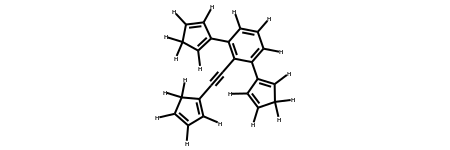

In [43]:
# Pick a random molecule in the space and get its smile string
rand_i = np.random.randint(315451)
saved_i = 3863
smi = p.iloc[rand_i]['molecule_smiles']

# Draw chem
rdkit_smi = Chem.AddHs(Chem.MolFromSmiles(smi))
rdkit_smi

In [44]:
p.iloc[rand_i]

molecule_smiles             C(#Cc1c(C2=CCC=C2)cccc1C1=CCC=C1)C1=CC=CC1
operation            [c:0]1[ch:1][ch][c:3][c!r5:4][c!r5:5]1>>[c:0]1...
molecule_last_gen           C(#Cc1c(-c2ccccc2)cccc1-c1ccccc1)C1=CC=CC1
generation                                                           4
XTB1_lamda_h                                                    133.07
ehomo_gfn1_b3lyp                                              -10.6066
symmetry                                                          True
Name: 9051, dtype: object

In [45]:
# Get molecular conformers of the substrate
substrate_confs = get_conformers(smi)
substrate = substrate_confs.pop()

# Relax
Esub = single_point(substrate, relaxation=True, trajectory='opt.traj', fmax=0.005)

Number of rotatable bonds: 2, C(#Cc1c(C2=CCC=C2)cccc1C1=CCC=C1)C1=CC=CC1
1) Embedding conformers (50). Using 1 processes
Took: 1.3321733474731445 s
2) Minimizing 50 conformers (mmff94)
Took: 2.0406644344329834 s
3) Pruning conformers (RMSD threshold: 0.35 Ang)
Took: 0.22996902465820312 s
Number of conformers found: 18


In [46]:
# Attach useful information to the substrate object
total_num_nonHs = len(substrate) - substrate.get_chemical_symbols().count('H') # number of non-hydrogen atoms

substrate.info['bonds'] = get_neighboring_bonds_list(substrate)
substrate.info['nonH_count'] = int(total_num_nonHs)

## eHOMO analysi

In [ ]:
# Hole potentials relative to SHE
hole_potentials = (-1. * p['ehomo_gfn1_b3lyp'].values - SHE_potential_vacuum) 

In [ ]:
hole_potentials.max()

## Main

In [ ]:
os.chdir('run')

TO-DO:

Now that you've done a scan of the PES for each adsorbate (see Adsorption Study below), we can move onto to the presumably simpler task of

    1. Scanning the PES to find the optimal * OH configuration/active-site and its adsorption energy
    2. Using this optimal active site * OH, to then calculate adsorption energy of * O and * OOH (upon relaxation)
    
Note: The optitum for OH is often not the optimum for O or OOH, however generally, all the low energy adsorbate intermediates share the same top 'k' active sites. Perhaps we need to choose multiple low energy candidate active sites in OH optimization step, to then subsequently screen in the O and OOH optimization steps. Or perhaps we need to be scanning using O or the most relavent intermediate!

Note2: Also, it could be that an OH config is most stable, but the O or OOH intermediate at the same active site leads to volitalization or a breaking of the substrate. Need to perform checks during each intermediate step to avoid this issue.

## Optimal Active Site

1. Relaxed active site scan using OH
    1. low fidelity: neighboring atoms to the site are free to move, while other non-H atoms are fixed
2. Determine minimum energy active sites and sequentially relax O and OOH atop these sites
    1. Ensuring that the O and OOH configs satisfy fidelity and active-site matching constraints
3. Perform final high fidelity relaxation on the resulting configurations (removing FixedAtoms constraints)

In [ ]:
def optimal_configurations(substrate, h=1.4, trajectory_fnames=['optOH', 'optO', 'optOOH']):
    
    ######## 1. OH low-fidelity relaxation and scan ##########################################################################
    
    # Generate configurations for each proposed site (site: non-H atom in substrate)
    configsOH = []
    for site in range(substrate.info['nonH_count']):
        constr_list =[Hookean_OH, FixAtoms(indices=fixed_nonH_neighbor_indices(site, substrate))]
        configsOH += build_configuration_from_site(OH, substrate, site, constr_list, f=h)

    # Relax configurations and keep legitimate ones
    relax_configurations(configsOH, trajectories=trajectory_fnames[0])
    configsOH_filtered = [config for config in configsOH if all(config.info['checks'])]
    
    # Rank active sites by adsorption energy
    Es_OH_sub = np.array([config.info['energy'] for config in configsOH_filtered])
    active_sites_configsOH = np.array([config.info['active_sites'][0] for config in configsOH_filtered])

    indx_sorted = Es_OH_sub.argsort()
    active_sites_ranked = active_sites_configsOH[indx_sorted]
    
    ######## 2. O and OOH relaxation #########################################################################################
    
    for j, _active_site in enumerate(active_sites_ranked):
        active_site = int(_active_site)

        print('Testing Active Site:', active_site)
        print('----------------------------------------')

        ### O intermediate
        # For candidate low-energy active site, build O* configs and relax
        constrO = [FixAtoms(indices=fixed_nonH_neighbor_indices(active_site, substrate))]
        configO = build_configuration_from_site(O, substrate, active_site, constrO, f=h)
        relax_configurations(configO, trajectories=trajectory_fnames[1])

        # Filter for legitimate configurations and active site matches
        configO_filtered = [config for config in configO if all(config.info['checks']) if active_site in config.info['active_sites']]

        if not len(configO_filtered):
            # No configs meet filtering criteria, skip to the next active site
            continue
        else:
            # Find min energy configuration and calculate desired properties
            energies = np.array([config.info['energy'] for config in configO_filtered])
            optimal_Oconfig = configO_filtered[energies.argmin()]

        ### OOH intermediate
        constrOOH = [Hookean_OOH_a, Hookean_OOH_b, FixAtoms(indices=fixed_nonH_neighbor_indices(active_site, substrate))]
        configOOH = build_configuration_from_site(OOH, substrate, active_site, constrOOH, f=h)
        relax_configurations(configOOH, trajectory_fnames[2])

        configOOH_filtered = [config for config in configOOH if all(config.info['checks']) if active_site in config.info['active_sites']]

        if not len(configOOH_filtered):
            continue
        else:
            optimal_active_site = active_site

            energies = np.array([config.info['energy'] for config in configOOH_filtered])
            optimal_OOHconfig = configOOH_filtered[energies.argmin()]

            optimal_OHconfig = configsOH_filtered[indx_sorted[j]]
            print('----------------------------------------')
            print("Optimal Active Site Found:", optimal_active_site)
            break
            
    return optimal_OHconfig, optimal_Oconfig, optimal_OOHconfig

## 1.

In [ ]:
### OH intermediate low-fidelity relaxed scan

# Generate configurations for each proposed site (site: non-H atom in substrate)
configsOH = []
h = 1.4

for site in range(substrate.info['nonH_count']):
    constr_list =[Hookean_OH, FixAtoms(indices=fixed_nonH_neighbor_indices(site, substrate))]
    configsOH += build_configuration_from_site(OH, substrate, site, constr_list, f=h)
    
# Relax configurations and keep legitimate ones
relax_configurations(configsOH, trajectories='optOH')
configsOH_filtered = [config for config in configsOH if all(config.info['checks'])]

In [ ]:
# Rank active sites by adsorption energy
Es_OH_sub = np.array([config.info['energy'] for config in configsOH_filtered])
active_sites_configsOH = np.array([config.info['active_sites'][0] for config in configsOH_filtered])

indx_sorted = Es_OH_sub.argsort()
active_sites_ranked = active_sites_configsOH[indx_sorted]

## 2.

In [ ]:
for j, _active_site in enumerate(active_sites_ranked):
    active_site = int(_active_site)
    
    print('Testing Active Site:', active_site)
    print('----------------------------------------')
    print('----------------------------------------')
    
    ### O intermediate
    # For candidate low-energy active site, build O* configs and relax
    constrO = [FixAtoms(indices=fixed_nonH_neighbor_indices(active_site, substrate))]
    configO = build_configuration_from_site(O, substrate, active_site, constrO, f=h)
    relax_configurations(configO)
    
    # Filter for legitimate configurations and active site matches
    configO_filtered = [config for config in configO if all(config.info['checks']) if active_site in config.info['active_sites']]
    
    if not len(configO_filtered):
        # No configs meet filtering criteria, skip to the next active site
        continue
    else:
        # Find min energy configuration and calculate desired properties
        energies = np.array([config.info['energy'] for config in configO_filtered])
        optimal_Oconfig = configO_filtered[energies.argmin()]
    
    ### OOH intermediate
    constrOOH = [Hookean_OOH_a, Hookean_OOH_b, FixAtoms(indices=fixed_nonH_neighbor_indices(active_site, substrate))]
    configOOH = build_configuration_from_site(OOH, substrate, active_site, constrOOH, f=h)
    relax_configurations(configOOH)

    configOOH_filtered = [config for config in configOOH if all(config.info['checks']) if active_site in config.info['active_sites']]
        
    if not len(configOOH_filtered):
        continue
    else:
        optimal_active_site = active_site
        
        energies = np.array([config.info['energy'] for config in configOOH_filtered])
        optimal_OOHconfig = configOOH_filtered[energies.argmin()]
        
        optimal_OHconfig = configsOH_filtered[indx_sorted[j]]
        print('----------------------------------------')
        print("Optimal Active Site Found:", optimal_active_site)
        break

## 3.

In [ ]:
# Remove constraints
del optimal_OHconfig.constraints, optimal_Oconfig.constraints, optimal_OOHconfig.constraints

In [ ]:
# and do a final relaxation and fidelity check
EOH_sub = single_point(optimal_OHconfig, relaxation=True, trajectory='optimumOH.traj', fmax=0.005)
EO_sub = single_point(optimal_Oconfig, relaxation=True, trajectory='optimumO.traj', fmax=0.005)
EOOH_sub = single_point(optimal_OOHconfig, relaxation=True, trajectory='optimumOOH.traj', fmax=0.005)

print("Fidelity Checks Passed:",
      all(site_identity_volatilization_checks(optimal_OHconfig, substrate)),
      all(site_identity_volatilization_checks(optimal_Oconfig, substrate)),
      all(site_identity_volatilization_checks(optimal_OOHconfig, substrate)))

In [ ]:
### Pickling for later use
substrate.write('substrate.xyz')
optimal_OHconfig.write('optimal_OHconfig.xyz')
optimal_Oconfig.write('optimal_Oconfig.xyz')
optimal_OOHconfig.write('optimal_OOHconfig.xyz')

## Thermodynamics

In [ ]:
def HOMO_LUMO_Energy(molecule, method='GFN2-xTB', accuracy=0.2, electronic_temperature=298.15):
    """
    Returns HOMO and LUMO energies (eV) of an ASE molecule. Molecule must have an ASE calculator instance already attached.
    Note: Conversion from ASE's use of Angstrom/eV, to xTB's use of Bohr/Hartree
    """
    num, pos = molecule.numbers, molecule.positions / Bohr
    
    if molecule.calc is None:
        calculator = Calculator(get_xtb_method(method), num, pos)
        calculator.set_accuracy(accuracy)
        calculator.set_electronic_temperature(electronic_temperature)
    else:
        params = molecule.calc.parameters
        calculator = Calculator(get_xtb_method(params['method']), num, pos)
        calculator.set_accuracy(params['accuracy'])
        calculator.set_electronic_temperature(params['electronic_temperature'])
    
    calculator.set_verbosity(VERBOSITY_MUTED)
    
    results = calculator.singlepoint()
    occup = results.get_orbital_occupations().astype(int)
    energies = results.get_orbital_eigenvalues()
    
    homo_indx = np.nonzero(occup)[0][-1] #Last non-zero orbital occupancy
    lumo_indx = homo_indx + 1
    
    return energies[homo_indx] * Hartree, energies[lumo_indx] * Hartree

In [ ]:
def zero_point_energy(molecule):
    ### Calculate vibrational modes by finite-diff. approximation of the Hessian and return the zero point energy (ZPE)
    displacement = 0.005*Bohr # Value used in 'xtb mol.xyz --hess'
    vib = Vibrations(molecule, delta=displacement)
    vib.run()
    vib.combine()
    vib_energy = vib.get_energies()
    vib.clean()
    
    if len(molecule) == 2:
        # Hydrogen molecule exception (3N-5 for linear molecule)
        num_modes = 1
    else:
        num_modes = 3 * len(molecule) - 6 # 3N-6 for nonlinear
        
    zpe = vib_energy[-num_modes:].sum().real / 2.
    return zpe

def free_energies(E_s, E_OH, E_O, E_OOH, ZPE_s, ZPE_OH, ZPE_O, ZPE_OOH):
    ### Total Energy (ZPE corrected) of *, *OH, *O, *OOH species
    
    dG1 = (E_OH + ZPE_OH) - (E_s + ZPE_s) + dG1_corr
    dG2 = (E_O + ZPE_O) - (E_OH + ZPE_OH) + dG2_corr
    dG3 = (E_OOH + ZPE_OOH) - (E_O + ZPE_O) + dG3_corr
    dG4 = (E_s + ZPE_s) - (E_OOH + ZPE_OOH) + dG4_corr
    
    return dG1, dG2, dG3, dG4

In [ ]:
def free_energy_plotter(Gs):

    x = [0, 1, 2, 3, 4]
    y = [0]+Gs.cumsum().tolist() # No bias
    y_123 = [0] + (Gs - 1.23).cumsum().tolist() # Equilibrium bias 1.23V
    y_downhill = [0] + (Gs - Gs.max()).cumsum().tolist() # Bias when all steps are down hill

    plt.step(x, y, 'k', label='0V')
    plt.step(x, y_123, '--k', label='1.23V')
    plt.step(x, y_downhill, 'b', label='{}V'.format(round(Gs.max(), 2)))

    plt.xlabel('Intermediates')
    plt.ylabel('Free Energy (eV)')
    plt.legend()

#### Energy of SHE relative to vacuum, where electrons are at rest
E(H+/H2, in H2O @ STP 298.15K/1.01325bar)(SHE) = 0 V

E(H+/H2, in H2O @ STP 298.15K/1.01325bar)(absolute) = 4.44 V ± 0.02 

#### Reference 
The absolute electrode potential: an explanatory note (Recommendations 1986)
S. Trasatti J. Electroanal. Chem. Interfacial Electrochem., 1986, 209 , 417 —428

### Free Energies

#### Free energy discussion from CH3. Fundamental Heterogenous Catalysis by Norskov

For historical reasons, G°, is also defined to be zero for the pure elements in their reference states. For other substances, G° is the reaction Gibbs energy for making the substances in their standard state from the constituting elements in their reference states. This is a point that one should be aware of, because its implication is that when using tabulated values, generally :

G° != H° - TS° or G != H - TS

The reason that the nonessential zero definition of the Gibbs energy has been made, even if it “messes up” one of the central expressions in physical chemistry, is that one typically always needs the Gibbs energies of reaction, not the absolute Gibbs energies themselves. The following relation will therefore still hold for the Gibbs energies of reaction:

∆G° = ∆H° −T∆S°

#### Entropy discussion
S = Strans + Srot + Svib + Sel

The standard entropy of small gas-phase molecules, such as N2 or CO, is of the order of 2meV/K. Their entropic contribution to the Gibbs free energy at room temperature (and at 1 bar) is therefore approximately −0.6eV/molecule. Most smaller molecules involved in heterogeneous catalysis have entropies of this order of magnitude; one important 
exception is H2 having a standard entropy of only 1.35meV/K.

By far, the largest fraction of the standard entropic contributions arises from the translations, which result in an enormous number of (particle-in-a-box type) energy states. The vibrational and rotational parts constitute a minor fraction of the gas-phase entropy. When a molecule adsorbs on the surface, it will lose a major part of its gas-phase entropy, as it loses the translational freedom from the gas phase. The translational and rotational degrees of freedom typically become constrained and turn into vibrational modes.

Now, unless there are a number of very-low-frequency vibrational modes of the adsorbed molecule on the surface (only frequencies that are around 50cm−1 or lower give significant contributions), it can be assumed as a rough approximation that the molecule loses all of its entropy upon adsorption.



In [ ]:
######## DO NOT RUN ANYMORE ########

### H2O and H2
H2 = ase.Atoms('2H', positions=[(0., 0., 0.), (0., 0., 0.8)])
H2O = ase.Atoms('HOH', positions=[[0, 0, -1], [0, 1, 0], [0, 0, 1]])

E_H2 = single_point(H2, relaxation=True, fmax=0.005)
ZPE_H2_DFT = zero_point_energy(H2)

E_H2O = single_point(H2O, relaxation=True, fmax=0.005)
ZPE_H2O_DFT = zero_point_energy(H2O)

In [ ]:
######## DO NOT RUN ANYMORE ########

######## Thermodynamic Quantities of Interest (in eV) ########

######## DFT derived E and ZPE ########
# GFN2-xTB, fmax=0.005 eV/Angstrom, accuracy=0.2

# Energy
E_H2 = -26.74025284322724
E_H2O = -137.9765422815829

# ZPE DFT
ZPE_H2_DFT = 0.2326865538281221
ZPE_H2O_DFT = 0.5475951786796269

######## Referenced ZPE and S ########
# Origin of the Overpotential for Oxygen Reduction at a Fuel-Cell Cathode
# https://doi.org/10.1021/jp047349j

# ZPE
ZPE_H2 = 0.27
ZPE_H2O = 0.56

# Gas Phase Entropies
TS_H2_g = 0.41
TS_H2O_g = 0.67

# H2(g) at 298.15k and 1bar (STP)
# H2O(g) at 298.15K and 0.035bar (at equilibrium with liquid water at the same temp.)
# So long as both these quanties are quoted w.r.t. same reference (i.e. STP), there shouldn't be problems when integrating them
# with DFT calculated energies, as we are only interested in taking differences of these quantites

######## Experimental water splitting free energy change ########
dG_ws = 2.46 # per water molecule

# Used to avoid problematic calculation of Oxygen gas free energy
# G_O2g = 2 * dG_ws + 2 * (G_H2O_l - G_H2_g), where the free energy of G_H2O_l = G_H2O_g at 298.15K and 0.035bar
# This as to avoid an inaccurate estimation of liquid free energy (hydrogen bond underestimation)

######## Free Energy Constants ########
# Since these variables are unchanging, the later half of each expression is constant, thus each reaction enthalpy (Δ(E + ZPE)) 
# is simply modified by a constant + dG_corr

#dG1 = (E_OH + ZPE_OH) - (E_s + ZPE_s) + 0.5 * (E_H2 + ZPE_H2) - (E_H2O + ZPE_H2O) - (0.5 * TS_H2_g - TS_H2O_g)
#dG2 = (E_O + ZPE_O) - (E_OH + ZPE_OH) + 0.5 * (E_H2 + ZPE_H2) - 0.5 * TS_H2_g
#dG3 = (E_OOH + ZPE_OOH) - (E_O + ZPE_O) + 0.5 * (E_H2 + ZPE_H2) - (E_H2O + ZPE_H2O) - (0.5 * TS_H2_g - TS_H2O_g)
#dG4 = (E_s + ZPE_s) - (E_OOH + ZPE_OOH) + 2 * dG_ws + 2 * (E_H2O + ZPE_H2O) - 3/2 * (E_H2 + ZPE_H2) - (2 * TS_H2O_g - 3/2 * TS_H2_g)


dG1_corr = 0.5 * (E_H2 + ZPE_H2) - (E_H2O + ZPE_H2O) - (0.5 * TS_H2_g - TS_H2O_g)
dG2_corr = 0.5 * (E_H2 + ZPE_H2) - 0.5 * TS_H2_g
dG3_corr = 0.5 * (E_H2 + ZPE_H2) - (E_H2O + ZPE_H2O) - (0.5 * TS_H2_g - TS_H2O_g)
dG4_corr = 2 * dG_ws + 2 * (E_H2O + ZPE_H2O) - 3/2 * (E_H2 + ZPE_H2) - (2 * TS_H2O_g - 3/2 * TS_H2_g)

# Defining static variables
dG1_corr, dG2_corr, dG3_corr, dG4_corr = 124.6464158599693, -13.44012642161362, 124.6464158599693, -230.93270529832492

# HOMO-LUMO and Free Energies

#### Homo-lumo

In [ ]:
eHOMO, eLUMO = HOMO_LUMO_Energy(substrate)

In [ ]:
print("HOMO Enegry (eV):", eHOMO)
print("LUMO Energy (eV):", eLUMO)

In [ ]:
water_redox_potential = 1.23 # Standard O2/H2O reduction potential relative to SHE (V)
SHE_potential_vacuum = 4.44 # SHE potential relative to vacuum energy
hole_potential = -eHOMO - SHE_potential_vacuum # relative to SHE

In [ ]:
print("Hole Potential (V):", hole_potential)
print("H2O Ox. Potential (V):", water_redox_potential)
print("In absence of theoretical overpotential, hole oxidizes water?:", hole_potential > water_redox_potential)

#### free energies

In [ ]:
### Reading substrate and intermediates
substrate = ase.io.read('substrate.xyz')
optimal_OHconfig = ase.io.read('optimal_OHconfig.xyz')
optimal_Oconfig = ase.io.read('optimal_Oconfig.xyz')
optimal_OOHconfig = ase.io.read('optimal_OOHconfig.xyz')

del substrate.calc, optimal_OHconfig.calc, optimal_Oconfig.calc, optimal_OOHconfig.calc

single_point(substrate), single_point(optimal_OHconfig), single_point(optimal_Oconfig), single_point(optimal_OOHconfig)

In [ ]:
# Static corrections to free energy expressions (in eV)
dG1_corr, dG2_corr, dG3_corr, dG4_corr = 124.6464158599693, -13.44012642161362, 124.6464158599693, -230.93270529832492

In [ ]:
### Adsorbed species (*, *OH, *O, *OOH)
# Assummed to have negligible entropy (TS_OH=TS_O=TS_OOH=0) - gas phase molecular entropy dominates
ZPEsub = zero_point_energy(substrate)
ZPEOH = zero_point_energy(optimal_OHconfig)
ZPEO = zero_point_energy(optimal_Oconfig)
ZPEOOH = zero_point_energy(optimal_OOHconfig)

In [ ]:
# Substrate-adsorbate energies
Es, EOH, EO, EOOH = substrate.get_potential_energy(), optimal_OHconfig.get_potential_energy(), optimal_Oconfig.get_potential_energy(), optimal_OOHconfig.get_potential_energy()

In [ ]:
g1, g2, g3, g4 = free_energies(Es, EOH, EO, EOOH, ZPEsub, ZPEOH, ZPEO, ZPEOOH)

In [ ]:
gs = np.array((g1, g2, g3, g4))

In [ ]:
print("Max Free Energy Change (eV):", gs.max())
print("Overpotential (V):", gs.max() - 1.23)
print("Rate Determining Step:", gs.argmax())

In [ ]:
free_energy_plotter(gs)

--------------------

In [ ]:
def parse_thermo_log(log_file):
    
    with open(log_file) as f:
        out = [line for line in f]
    
    for j, line in enumerate(out):
        ## Extract thermodynamic quanties
        ## [T, H(0)-H(T)+pV, H(T), T*S, G(T)]
        if 'T/K' in line:
            thermo_vars = line.split()
            thermo_quantities = out[j+2].split()
            thermo_quantities = np.array(thermo_quantities).astype(float) * Hartree
        ## Extract ZPE
        if 'zero point energy' in line:
            zpe = float(line.split()[4]) * Hartree
            
    return thermo_quantities[1:], zpe

In [ ]:
#XTB slop

# os.mkdir('xtb_run')
# os.chdir('xtb_run')

H2.write('H2.xyz')
H2O.write('H2O.xyz')

coord_H2O = 'H2O.xyz'
coord_H2 = 'H2.xyz'

cmd_vib = 'xtb {} --hess --gfn 2 --acc 0.2 --etemp 298.15 --chrg 0 --strict'.format(coord_H2O)
cmd_thermo = 'xtb thermo --temp 298.15 {} hessian > log.txt'.format(coord_H2O)

os.system(cmd_vib)

os.system(cmd_thermo)

### Determined from prior xTB calculations using thermo module
# Compute vibration frequencies from an already optimized structure
# cmd = 'xtb {xyz_coord_file} --hess --gfn 2 --acc 0.2 --etemp 298.15 --chrg 0'
#
# Then call the thermochemistry module using the resulting hessian
# cmd = 'xtb thermo --temp 298.15 {xyz_coord_file} hessian > log.txt'
# Then parse, parse_thermo_log('log.txt')
## Note: thermochemical analysis of hydrogen is causing overflow errors for some reason
# Use zpe taken from following reference: Origin of the overpotential for oxygen reduction reaction by Norskov et al.

zpe_H2O = 0.5476081713265313
thermo_quants = ['H(0)-H(T)+pV', 'H(T)', 'T*S', 'G(T)']
thermodynamic_quantites_H2O_298K_DFT_RRHO = [8.11307474e+03, 1.02886523e-01, 6.50493625e-01, 5.82299171e-01, 6.81958151e-02]

zpe_H2 = 0.27
# thermodynamic_quantites_H2_298K = 

https://univ-angers.hal.science/hal-02326425/document

Triphenylamine HOMO and LUMO for comparison

#### poly-phenelyne

https://doi.org/10.1039/C4TA02044H

In literature, PPP is found to have the necessary hole_energy/IP to oxidize water.... i.e. the potential of the holes is more positive than 1.23V (reduction potential of O2/H2O).

DFT calculations using water as an implicit solvent, find that PPP7 has a IP of 1.08 V, with PPP2 having an even more positive potential. The presence of the solvent apparently causes the IP (potential of the free hole) to become more negative by approximately ~1 volt. Thus, without the solvent, we would expect an IP for PPP of approximately ~ 2 V. This is, more or less what we calculate below, when n=4 is used. Thus, under the influence of a solvent, we would expect that thermodynamic driving potential of the hole to decrease (become more negative).

In [ ]:
phenelyne2 = 'C1=CC=CC=C1C2=CC=CC=C2'
phenelyne7 = "C1=CC=C(C=C1)C2=CC=C(C=C2)C3=CC=C(C=C3)C4=CC=C(C=C4)C5=CC=C(C=C5)C6=CC=C(C=C6)C7=CC=C(C=C7)"
PPP2 = get_conformers(phenelyne2)[0]
PPP7 = get_conformers(phenelyne7)[0]

In [ ]:
single_point(PPP2, relaxation=True), single_point(PPP7, relaxation=True)

In [ ]:
eHOMOp2, eLUMOp2 = HOMO_LUMO_Energy(PPP2)
eHOMOp7, eLUMOp7 = HOMO_LUMO_Energy(PPP7)

In [ ]:
-eHOMOp2, -eHOMOp7

Using IPEA for estimating IP and EA

In [ ]:
PPP2.write('PPP2.xyz'), PPP7.write('PPP7.xyz')

In [ ]:
os.system('xtb PPP2.xyz --vip')

----------------------------------------------------

# ---------------------------------------------------------------------------------------------------------------

## Adsorption Study for OH, O, OOH

OH

In [ ]:
constr_list =[[Hookean_OH, FixAtoms(indices=fixed_nonH_neighbor_indices(site, substrate))] for site in range(substrate.info['nonH_count'])]
configsOH = build_configuration_space(OH, substrate, constr_list)
relax_configurations(configsOH, trajectories='optOH')

# Filter configs if checks pass
configsOH_filtered = [config for config in configsOH if all(config.info['checks'])]

In [ ]:
EOH_sub = np.array([config.info['energy'] for config in configsOH])
EadsorptionOH = EOH_sub - (EOH + Esub)

O

In [ ]:
constr_list =[[FixAtoms(indices=fixed_nonH_neighbor_indices(site, substrate))] for site in range(substrate.info['nonH_count'])]
configsO = build_configuration_space(O, substrate, constr_list)
relax_configurations(configsO, trajectories='optO')

configsO_filter = [config for config in configsO if all(config.info['checks'])]

In [ ]:
EO_sub = np.array([config.info['energy'] for config in configsO])
EadsorptionO = EO_sub - (EO + Esub)

OOH

In [ ]:
constr_list =[[Hookean_OOH_a, Hookean_OOH_b, FixAtoms(indices=fixed_nonH_neighbor_indices(site, substrate))] for site in range(substrate.info['nonH_count'])]
configsOOH = build_configuration_space(OOH, substrate, constr_list)
relax_configurations(configsOOH, trajectories='optOOH')

configsOOH_filtered = [config for config in configsOOH if all(config.info['checks'])]

In [ ]:
EOOH_sub = np.array([config.info['energy'] for config in configsOOH])
EadsorptionOOH = EOOH_sub - (EOOH + Esub)

Summary

In [ ]:
d1 = [config.info['active_sites'][0] for _, config in sorted(zip(EadsorptionOH, configsOH))]

In [ ]:
d2 = [config.info['active_sites'] for _, config in sorted(zip(EadsorptionO, configsO))]

In [ ]:
d3 = [config.info['active_sites'][0] for _, config in sorted(zip(EadsorptionOOH, configsOOH))]

In [ ]:
pd.DataFrame([d1, d2, d3]).T

In [ ]:
top_active_sites = 5

In [ ]:
d1_top = d1[:top_active_sites]
d2_top = [x for l in d2[:top_active_sites] for x in l]
d3_top = d3[:top_active_sites]

In [ ]:
d1_top, d3_top

In [ ]:
d2_top